In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd


In [2]:
%matplotlib inline

In [3]:
#load data

In [4]:
daily_df = pd.read_csv("dataset/stations_daily.csv")

In [5]:
# hourly_df = pd.read_csv("dataset/stations_hourly.csv")

In [6]:
rsinaica_df = pd.read_csv("dataset/stations_rsinaica.csv")

# จัดการกับข้อมูลรายงานฝุ่นรายวันก่อน

we will use this dataframe to calculate the yearly statistic of ฝุ่น

In [7]:
daily_df.head()

,datetime,station_id,PM2.5,PM10,NOx,O3,CO,HR,NO,NO2,...,HCT,HRI,IUV,PB,PP,PST,RS,TMPI,UVA,XIL
0,2015-04-02,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.361000,NaN,NaN
1,2015-05-21,32,0.454967,0.347400,0.059194,0.029176,NaN,44.879091,0.029525,0.053121,...,NaN,NaN,NaN,570.775455,0.296364,NaN,7.871636,16.792818,NaN,NaN
2,2015-05-22,32,0.077821,0.389323,0.019158,0.051903,NaN,42.506000,0.009589,0.014215,...,NaN,NaN,NaN,558.360000,0.002750,NaN,384.788079,17.018949,NaN,NaN
3,2015-05-23,32,0.018036,0.387729,0.019711,0.021092,0.144603,54.734437,0.009863,0.013436,...,NaN,NaN,NaN,573.282187,0.038750,NaN,252.605975,18.575000,NaN,NaN
4,2015-05-24,32,0.024935,0.398042,0.024757,0.009568,0.494143,58.374574,0.012397,0.010337,...,NaN,NaN,NaN,572.169574,0.003404,NaN,259.231664,16.781064,NaN,NaN


Let's add year and month columns to daily_df 

In [8]:
daily_df.insert(1, "year", daily_df["datetime"].apply(lambda x: x.split("-")[0]))
daily_df.insert(1, "month", daily_df["datetime"].apply(lambda x: x.split("-")[1]))

convert month and year to int \
then sort values by month and year

In [9]:
daily_df["month"] = pd.to_numeric(daily_df["month"])
daily_df["year"] = pd.to_numeric(daily_df["year"])

daily_df.sort_values(by=["year", "month"], inplace = True)
daily_df

,datetime,month,year,station_id,PM2.5,PM10,NOx,O3,CO,HR,...,HCT,HRI,IUV,PB,PP,PST,RS,TMPI,UVA,XIL
59820,2000-01-01,1,2000,102,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59821,2000-01-02,1,2000,102,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59822,2000-01-03,1,2000,102,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59823,2000-01-04,1,2000,102,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59824,2000-01-05,1,2000,102,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231587,2021-12-27,12,2021,426,28.956522,67.375000,0.036429,0.030750,1.684583,56.541667,...,NaN,NaN,NaN,708.600000,0.0,NaN,136.416667,NaN,NaN,NaN
231588,2021-12-28,12,2021,426,20.818182,55.833333,0.037508,0.026792,1.700000,44.375000,...,NaN,NaN,NaN,705.670833,0.0,NaN,136.875000,NaN,NaN,NaN
231589,2021-12-29,12,2021,426,16.857143,51.458333,0.045588,0.017083,1.732917,37.875000,...,NaN,NaN,NaN,707.687500,0.0,NaN,108.708333,NaN,NaN,NaN
231590,2021-12-30,12,2021,426,21.555556,51.750000,0.037229,0.029833,1.520000,42.916667,...,NaN,NaN,NaN,710.141667,0.0,NaN,129.666667,NaN,NaN,NaN


count the values exist each year

In [10]:
groupDaily_by_year = daily_df.groupby("year")
groupDaily_by_year.count()

,datetime,month,station_id,PM2.5,PM10,NOx,O3,CO,HR,NO,...,HCT,HRI,IUV,PB,PP,PST,RS,TMPI,UVA,XIL
year,,,,,,,,,,,,,,,,,,,,,
2000,1678,1678,1678,0,0,0,0,0,0,1678,...,0,0,0,0,0,0,0,0,0,0
2001,1658,1658,1658,0,0,0,0,0,0,1658,...,0,0,0,0,0,0,0,0,0,0
2002,826,826,826,0,0,0,0,0,0,826,...,0,0,0,0,0,0,0,0,0,0
2006,321,321,321,0,0,0,0,0,0,321,...,0,0,0,0,0,0,0,0,0,0
2007,44,44,44,0,0,0,0,0,0,44,...,0,0,0,0,0,0,0,0,0,0
2008,43,43,43,0,0,0,0,0,0,43,...,0,0,0,0,0,0,0,0,0,0
2009,43,43,43,0,0,0,0,0,0,43,...,0,0,0,0,0,0,0,0,0,0
2010,10417,10417,10417,3814,7612,151,8235,6816,151,1069,...,0,0,0,140,0,0,0,0,0,0
2011,11315,11315,11315,5374,8473,61,10057,6298,65,1836,...,0,29,0,36,27,0,0,25,0,0


In [11]:
# we will keep a year if PM2.5 have data > 50 %
def keep_year(group):
    return ((group.count()["PM2.5"] * 100) / group.count()["datetime"] > 70)
daily_df = groupDaily_by_year.filter(keep_year)

filter data

In [12]:
daily_df = groupDaily_by_year.filter(keep_year)
daily_df["year"].unique()

array([2015, 2016, 2017, 2018, 2019, 2020, 2021])

next we will drop column which have few data

In [13]:
daily_df.isna().sum()* 100 / len(daily_df)

#show % of Nan values in each column, we will drop at 51 %

datetime        0.000000
month           0.000000
year            0.000000
station_id      0.000000
PM2.5          20.853479
PM10           19.873434
NOx            31.088876
O3             16.907166
CO             20.951172
HR             24.931708
NO             33.656904
NO2            24.835259
TMP            22.710896
BEN            99.517756
CH4            99.831992
CN             99.629761
CO2            99.965154
H2S            99.825770
HCNM           99.826392
HCT           100.000000
HRI            94.081154
IUV            96.929194
PB             44.164224
PP             54.761149
PST           100.000000
RS             54.108408
TMPI           79.033272
UVA            90.760826
XIL            99.517756
dtype: float64

Too many Nan values OMG

In [14]:
for col in daily_df:
    if daily_df[col].isna().sum()* 100 / len(daily_df) > 40:
        daily_df.drop(col, axis=1,inplace=True)
daily_df.reset_index(drop = True)
daily_df[daily_df["year"]==2021]["CO"].sort_values(ascending=False)

/usr/lib/python3/dist-packages/pandas/core/frame.py:4110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


9667      84087.353799
9855      21549.133333
9854      21034.714286
9853      17450.238095
9852      17067.208333
              ...     
224414             NaN
224415             NaN
224416             NaN
224417             NaN
224418             NaN
Name: CO, Length: 23164, dtype: float64

In [15]:
# daily_df.fillna(method="ffill")

## Let see if we have an outlier

In [16]:
daily_df.describe()

# noone can life with those pm2.5 and pm10 haha

,month,year,station_id,PM2.5,PM10,NOx,O3,CO,HR,NO,NO2,TMP
count,160707.000000,160707.000000,160707.000000,1.271940e+05,1.287690e+05,1.107450e+05,133536.000000,127037.000000,1.206400e+05,1.066180e+05,1.207950e+05,124209.000000
mean,6.608094,2018.192555,176.140734,2.830052e+33,1.832171e+33,2.906423e+01,0.548284,3.340298,2.316232e+02,3.003726e+01,2.654576e+01,24.307164
std,3.450505,1.909545,97.898844,6.201747e+35,4.357159e+35,9.585072e+03,145.560632,276.000146,5.077423e+04,9.768822e+03,9.177681e+03,633.620598
min,1.000000,2015.000000,32.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,4.000000,2017.000000,93.000000,1.214669e+01,2.994232e+01,1.420000e-02,0.018996,0.500000,4.351037e+01,4.577356e-03,8.558333e-03,15.981167
50%,7.000000,2018.000000,142.000000,1.866534e+01,4.491667e+01,2.389649e-02,0.025971,0.753667,5.745455e+01,9.150156e-03,1.463492e-02,19.233333
75%,10.000000,2020.000000,260.000000,2.714147e+01,6.439130e+01,3.914257e-02,0.034231,1.150000,6.900000e+01,1.791667e-02,2.265548e-02,22.983542
max,12.000000,2021.000000,426.000000,1.806160e+38,1.412893e+38,3.189756e+06,53185.473851,84087.353799,1.736131e+07,3.189756e+06,3.189756e+06,202409.533333


In [17]:
# def outliers(df,col):
#     Q1 = df[col].quantile(0.25)
#     Q3 = df[col].quantile(0.75)
#     IQR = Q3-Q1

#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR

#     ls = df.index[ (df[col] < lower_bound) | (df[col] > upper_bound) ]
#     return ls

# index_list = []
# for col in ["PM2.5", "PM10", "NOx", "O3", "CO", "HR", "NO", "NO2", "TMP"]:
#     index_list.extend(outliers(daily_df, col))

In [18]:
# daily_df.drop(set(index_list), inplace=True)
# daily_df.reset_index(drop = True)

In [19]:
# drop overrated data
# ไปถาม chat มา เดี๋ยวไปหา ref ใหม่
ls = []
ls.extend(daily_df.index[(daily_df["PM2.5"]>125) | (daily_df["PM10"]>1020) | (daily_df["NOx"]>0.45) | (daily_df["O3"]>0.2) | (daily_df["CO"]>40)
| (daily_df["HR"]>100) | (daily_df["NO"]>0.45) | (daily_df["NO2"]>0.45) | (daily_df["TMP"]>52)])

ls.extend(daily_df.index[(daily_df["PM2.5"]==0) & (daily_df["PM10"]==0)])
daily_df.drop(set(ls), inplace=True)
daily_df = daily_df.replace(0, np.nan)
daily_df = daily_df.reset_index(drop=True)

In [20]:
# fillna with average of that specific time
ls.clear()
for i in daily_df["year"].unique():
    for j in range(1, 13):
        ls.extend(daily_df.index[(daily_df["year"]==i) & (daily_df["month"]==j)])
    daily_df.loc[min(ls):max(ls)] = daily_df.loc[min(ls):max(ls)].fillna(daily_df[min(ls):max(ls)].mean())
    ls.clear()
daily_df

,datetime,month,year,station_id,PM2.5,PM10,NOx,O3,CO,HR,NO,NO2,TMP
0,2015-01-01,1,2015,74,58.463104,151.492087,0.105343,0.020424,1.885726,48.521913,0.069582,0.035762,20.059348
1,2015-01-02,1,2015,74,23.176346,95.715250,0.063575,0.018688,1.183263,44.274875,0.036966,0.026609,20.507292
2,2015-01-03,1,2015,74,17.524446,75.196208,0.065822,0.016365,1.158183,46.550208,0.042984,0.022838,19.614250
3,2015-01-04,1,2015,74,15.794987,77.297125,0.038281,0.021169,0.837088,49.585542,0.021857,0.016424,18.225083
4,2015-01-05,1,2015,74,8.660900,57.438542,0.035275,0.027931,0.778861,44.201000,0.020107,0.015169,16.027417
...,...,...,...,...,...,...,...,...,...,...,...,...,...
153119,2021-12-27,12,2021,426,28.956522,67.375000,0.036429,0.030750,1.684583,56.541667,0.010809,0.024762,21.660833
153120,2021-12-28,12,2021,426,20.818182,55.833333,0.037508,0.026792,1.700000,44.375000,0.010809,0.023225,23.731250
153121,2021-12-29,12,2021,426,16.857143,51.458333,0.045588,0.017083,1.732917,37.875000,0.010809,0.026500,22.751250
153122,2021-12-30,12,2021,426,21.555556,51.750000,0.037229,0.029833,1.520000,42.916667,0.010809,0.023929,22.988333


In [21]:
daily_df.describe()

,month,year,station_id,PM2.5,PM10,NOx,O3,CO,HR,NO,NO2,TMP
count,153124.000000,153124.000000,153124.000000,153124.000000,153124.000000,1.531240e+05,1.531240e+05,1.531240e+05,153124.000000,1.531240e+05,1.531240e+05,153124.000000
mean,6.604262,2018.207002,178.465629,20.929927,56.826699,3.108678e-02,2.733224e-02,1.087610e+00,55.953240,1.509266e-02,1.677682e-02,19.371914
std,3.449850,1.924205,96.977993,11.464313,75.919595,2.153124e-02,1.105287e-02,1.767666e+00,15.698666,1.599708e-02,9.725726e-03,4.581147
min,1.000000,2015.000000,32.000000,0.000313,0.007538,1.490278e-07,8.109665e-07,5.877500e-39,0.008646,1.298958e-07,8.509144e-08,0.080000
25%,4.000000,2017.000000,102.000000,13.970699,34.000000,1.883333e-02,2.080438e-02,5.817356e-01,48.958333,6.845455e-03,1.084913e-02,16.968318
50%,7.000000,2018.000000,143.000000,20.107243,49.793951,2.739192e-02,2.686957e-02,9.062043e-01,57.371572,1.169170e-02,1.579024e-02,19.033794
75%,10.000000,2020.000000,260.000000,23.976495,63.321174,3.908412e-02,3.206339e-02,1.167161e+00,64.458644,1.731959e-02,2.067187e-02,21.643050
max,12.000000,2021.000000,426.000000,124.990382,1000.699997,4.478375e-01,1.994583e-01,3.999737e+01,100.000000,4.025364e-01,3.863000e-01,48.235583


fillna

In [22]:
# for y in daily_df["year"].unique():
#     for m in daily_df["month"].unique():
#         daily_df.update(daily_df.loc[(daily_df["year"]==y) & (daily_df["month"]==m),"PM2.5"].fillna(add_PM2_5[y][m]["mean"]))
#         daily_df.update(daily_df.loc[(daily_df["year"]==y) & (daily_df["month"]==m),"PM10"].fillna(add_PM10[y][m]["mean"]))



In [23]:
group_y = daily_df.groupby("year")
group_y["PM2.5"].mean()
daily_df.describe()

,month,year,station_id,PM2.5,PM10,NOx,O3,CO,HR,NO,NO2,TMP
count,153124.000000,153124.000000,153124.000000,153124.000000,153124.000000,1.531240e+05,1.531240e+05,1.531240e+05,153124.000000,1.531240e+05,1.531240e+05,153124.000000
mean,6.604262,2018.207002,178.465629,20.929927,56.826699,3.108678e-02,2.733224e-02,1.087610e+00,55.953240,1.509266e-02,1.677682e-02,19.371914
std,3.449850,1.924205,96.977993,11.464313,75.919595,2.153124e-02,1.105287e-02,1.767666e+00,15.698666,1.599708e-02,9.725726e-03,4.581147
min,1.000000,2015.000000,32.000000,0.000313,0.007538,1.490278e-07,8.109665e-07,5.877500e-39,0.008646,1.298958e-07,8.509144e-08,0.080000
25%,4.000000,2017.000000,102.000000,13.970699,34.000000,1.883333e-02,2.080438e-02,5.817356e-01,48.958333,6.845455e-03,1.084913e-02,16.968318
50%,7.000000,2018.000000,143.000000,20.107243,49.793951,2.739192e-02,2.686957e-02,9.062043e-01,57.371572,1.169170e-02,1.579024e-02,19.033794
75%,10.000000,2020.000000,260.000000,23.976495,63.321174,3.908412e-02,3.206339e-02,1.167161e+00,64.458644,1.731959e-02,2.067187e-02,21.643050
max,12.000000,2021.000000,426.000000,124.990382,1000.699997,4.478375e-01,1.994583e-01,3.999737e+01,100.000000,4.025364e-01,3.863000e-01,48.235583


# Heatmap correlation

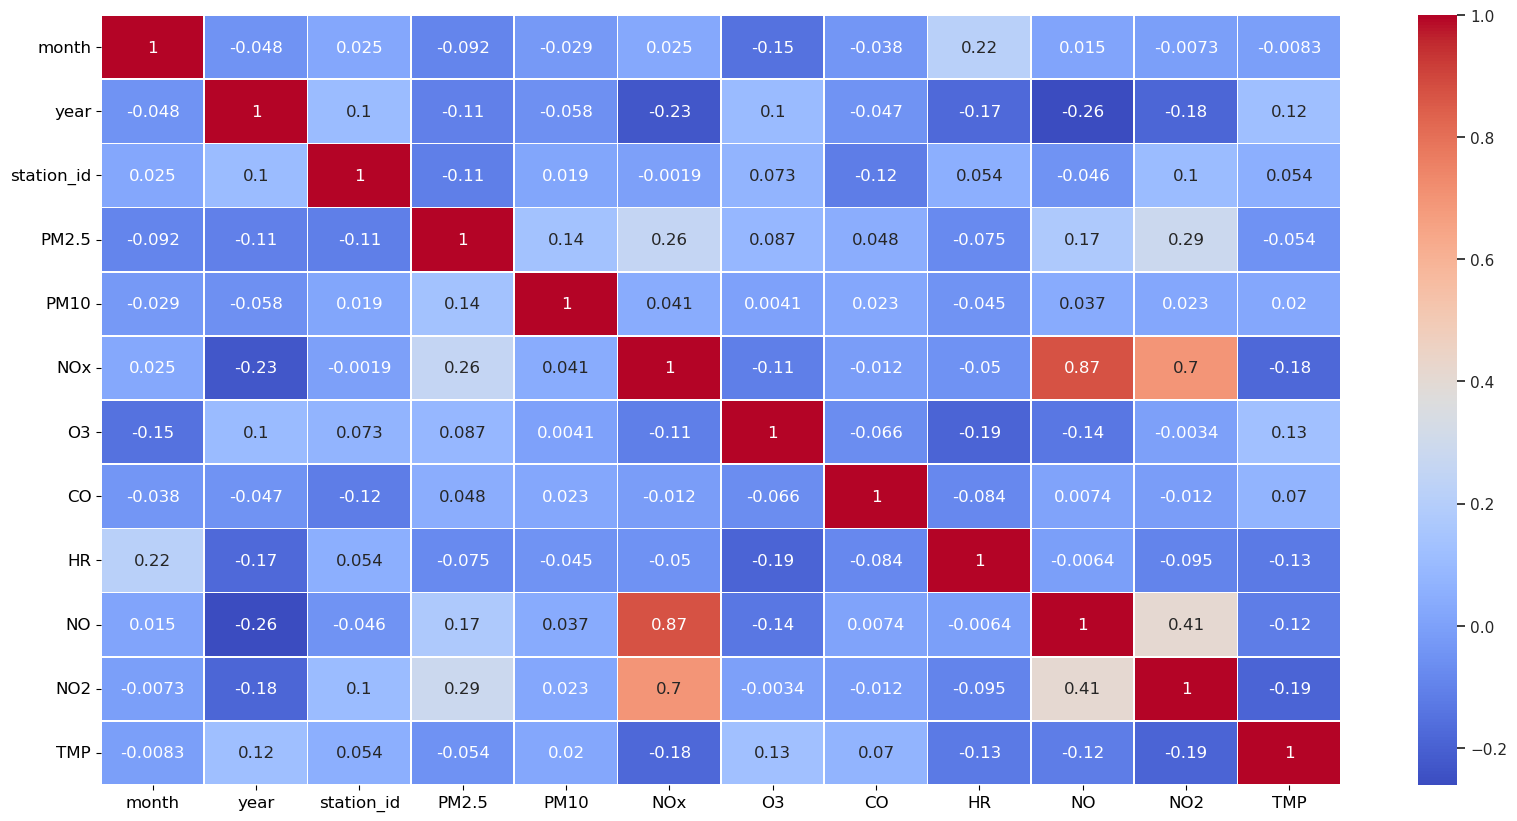

In [24]:
data_to_corr = daily_df.iloc[:,1:]
plt.gcf().set_size_inches(20, 10)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
sns.set(font_scale=1)
dataplot = sns.heatmap(data_to_corr.corr(), cmap="coolwarm", annot = True, linewidths=.5)

# Graph PM2.5 and PM10

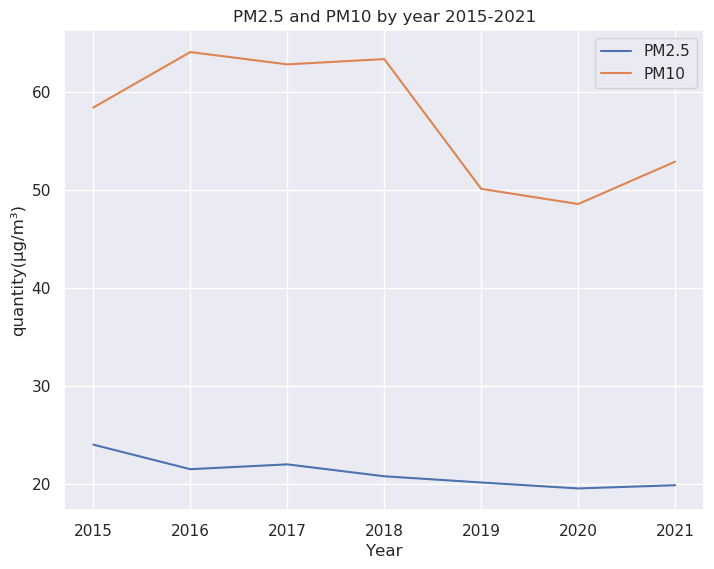

In [25]:
line_Graph = plt.figure()

ax = line_Graph.add_axes([0,0,1,1])
ax.set_title('PM2.5 and PM10 by year 2015-2021')
plt.xlabel('Year')
plt.ylabel('quantity(µg/m³)')
ax.plot(group_y["PM2.5"].mean(), label="PM2.5")
ax.plot(group_y["PM10"].mean(), label="PM10")
ax.legend()

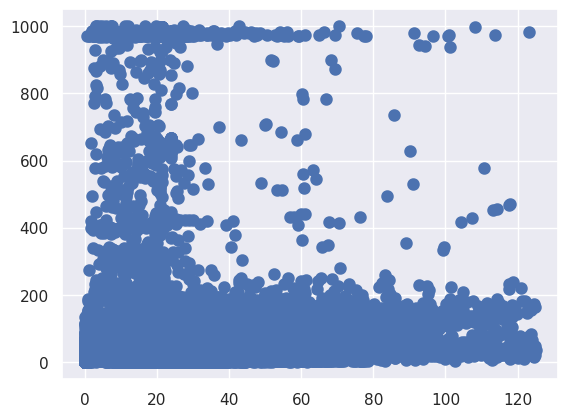

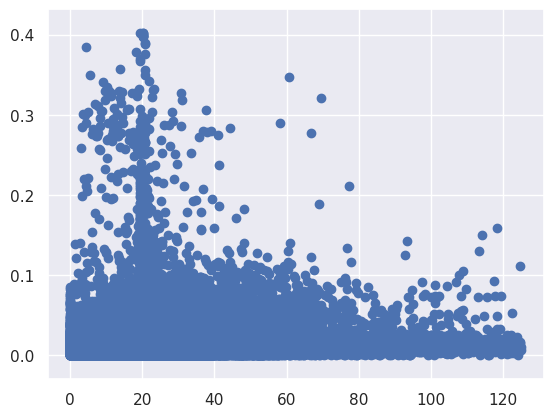

In [26]:
plt.scatter(daily_df["PM2.5"], daily_df["PM10"], linewidths=3)
plt.show()
plt.scatter(daily_df["PM2.5"], daily_df["NO"])

In [27]:
# p1_df = pd.DataFrame({"Average PM2.5": daily_df.groupby("year")["PM2.5"].mean()}).reset_index()
# p1_df
# p1_df.plot("year", "Average PM2.5", kind='bar', color="#337fff", width=0.5);
# plt.xlabel('Year')
# plt.ylabel('PM2.5 quantity(µg/m³)')
# plt.yticks(fontsize=20)
# plt.xticks(fontsize=20)
# plt.legend()
# plt.xticks(rotation = 45)

# statistic by season

In [28]:
# month with avr
daily_df.groupby("month").mean()

,year,station_id,PM2.5,PM10,NOx,O3,CO,HR,NO,NO2,TMP
month,,,,,,,,,,,
1,2018.337421,174.436804,23.563114,64.682145,0.038538,0.023781,1.287563,52.969235,0.019327,0.020014,15.912132
2,2018.322503,175.325675,22.578261,62.871000,0.035448,0.025844,1.290140,50.120670,0.018073,0.018832,17.673442
3,2018.303075,176.895333,22.336250,61.026558,0.029957,0.029140,1.184728,49.086494,0.013802,0.017168,19.384336
4,2018.294122,175.878823,24.247598,65.679184,0.027899,0.033897,1.129802,47.034095,0.012940,0.016261,20.741617
5,2018.284906,176.676065,24.359877,59.910934,0.026545,0.034847,1.043308,51.686228,0.012211,0.015387,21.762135
6,2018.252196,177.584632,18.332164,47.453514,0.025641,0.029773,0.991590,58.762069,0.012426,0.014239,21.476115
7,2018.212386,178.263754,18.595935,49.460953,0.027181,0.028103,1.006740,61.338905,0.013369,0.014693,20.825290
8,2018.125723,180.421309,17.294527,45.420048,0.026720,0.027148,0.973093,61.897331,0.012923,0.014586,20.930135
9,2018.118773,181.477463,17.166899,46.741445,0.027554,0.025672,0.955316,63.956612,0.013500,0.014926,20.252910


In [29]:
# In Mexico, hot season are 1, 2, 3, 4, 11, 12
hot_s = daily_df.groupby("month").mean().drop([5, 6, 7, 8, 9, 10]).mean().to_frame().T.assign(season=["hot_season"]).set_index("season")
hot_s

,year,station_id,PM2.5,PM10,NOx,O3,CO,HR,NO,NO2,TMP
season,,,,,,,,,,,
hot_season,2018.239447,177.434336,23.103872,63.229802,0.034754,0.026435,1.189919,51.939216,0.016851,0.018625,17.966291


In [30]:
# In Mexico, wet season are 5, 6, 7, 8, 9, 10
wet_s = daily_df.groupby("month").mean()[4:10].mean().to_frame().T.assign(season=["wet_season"]).set_index("season")
wet_s

,year,station_id,PM2.5,PM10,NOx,O3,CO,HR,NO,NO2,TMP
season,,,,,,,,,,,
wet_season,2018.180383,179.34482,18.843612,50.611584,0.027403,0.028345,0.990139,59.71443,0.013333,0.014943,20.777654


In [31]:
# merge season
season = hot_s.append(wet_s)
season

,year,station_id,PM2.5,PM10,NOx,O3,CO,HR,NO,NO2,TMP
season,,,,,,,,,,,
hot_season,2018.239447,177.434336,23.103872,63.229802,0.034754,0.026435,1.189919,51.939216,0.016851,0.018625,17.966291
wet_season,2018.180383,179.344820,18.843612,50.611584,0.027403,0.028345,0.990139,59.714430,0.013333,0.014943,20.777654


### compare wet and hot season

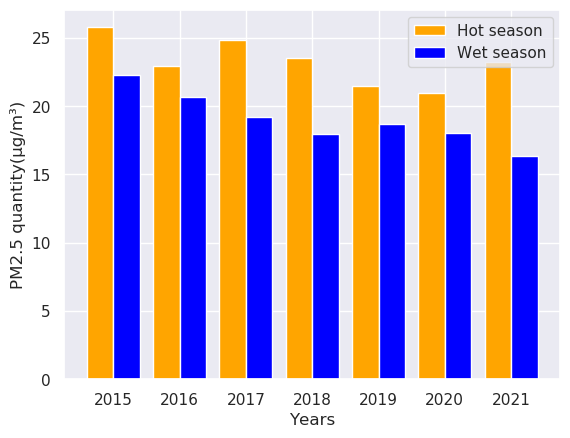

In [32]:
hot_s_list, wet_s_list = [], []
year = list(range(2015, 2022))
x = np.arange(7)
for i in year:
    hot_s_list.append(daily_df[daily_df["year"] == i].groupby("month").mean().drop([5, 6, 7, 8, 9, 10]).mean()["PM2.5"])
    wet_s_list.append(daily_df[daily_df["year"] == i].groupby("month").mean()[4:10].mean()["PM2.5"])

plt.bar(x-0.2, hot_s_list, 0.4, color="orange")
plt.bar(x+0.2, wet_s_list, 0.4, color="blue")
plt.xticks(x, year)
plt.xlabel("Years")
plt.ylabel("PM2.5 quantity(µg/m³)")
plt.legend(["Hot season", "Wet season"])
plt.show()

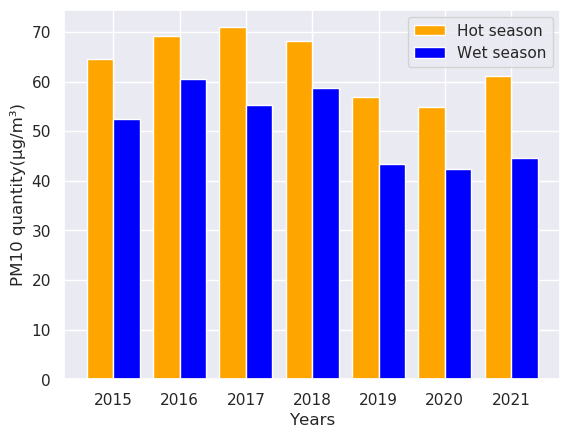

In [33]:
hot_s_list, wet_s_list = [], []
for i in year:
    hot_s_list.append(daily_df[daily_df["year"] == i].groupby("month").mean().drop([5, 6, 7, 8, 9, 10]).mean()["PM10"])
    wet_s_list.append(daily_df[daily_df["year"] == i].groupby("month").mean()[4:10].mean()["PM10"])

plt.bar(x-0.2, hot_s_list, 0.4, color="orange")
plt.bar(x+0.2, wet_s_list, 0.4, color="blue")
plt.xticks(x, year)
plt.xlabel("Years")
plt.ylabel("PM10 quantity(µg/m³)")
plt.legend(["Hot season", "Wet season"])
plt.show()

# hourly_df

In [34]:
# hourly_df.head()

In [35]:
# for y in daily_df["year"].unique()[3:]:
#     value = (mean_y[y])
#     print(y)
#     (daily_df[daily_df["year"]==y]["PM2.5"].fillna(value, inplace = True))


In [36]:
daily_df[daily_df["year"] == 2010]["PM10"]

Series([], Name: PM10, dtype: float64)

In [37]:
# hourly_df.drop_duplicates(["datetime", "station_id"])
# hourly_df.sort_values("datetime")

# rsinaica_df

In [38]:
rsinaica_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341 entries, 0 to 340
Data columns (total 27 columns):
station_id           341 non-null int64
station_name         341 non-null object
station_code         341 non-null object
network_id           341 non-null int64
network_name         334 non-null object
network_code         340 non-null object
street               187 non-null object
ext                  154 non-null object
interior             74 non-null object
colonia              186 non-null object
zip                  143 non-null object
state_code           299 non-null float64
municipio_code       299 non-null float64
year_started         138 non-null float64
altitude             320 non-null float64
address              138 non-null object
date_validated       20 non-null object
date_validated2      143 non-null object
passed_validation    162 non-null float64
video                55 non-null object
lat                  316 non-null float64
lon                  316 non-null

In [39]:
rsinaica_df

#network_name is city

,station_id,station_name,station_code,network_id,network_name,network_code,street,ext,interior,colonia,...,date_validated2,passed_validation,video,lat,lon,date_started,timezone,street_view,video_interior,color
0,397,"CENICA 1, UAM Iztapalapa",CEN,144,NaN,ESTSP,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,19.489583,-98.801083,2002-01-01,"Tiempo del centro, UTC-6 (UTC-5 en verano)",NaN,NaN,Others
1,344,C. Salud Tlaxcoapán,TCP,127,NaN,TCP,NaN,NaN,NaN,NaN,...,NaN,NaN,Array,20.091472,-99.228417,NaN,"Tiempo del centro, UTC-6 (UTC-5 en verano)",NaN,NaN,Others
2,365,Costa Baja,UM,140,NaN,LAP,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2010-03-14,"Tiempo del centro, UTC-6 (UTC-5 en verano)",NaN,NaN,Others
3,393,Unidad Móvil de Hidalgo,UMHI,143,NaN,POP,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,19.489583,-98.801083,2013-05-24,"Tiempo del centro, UTC-6 (UTC-5 en verano)",NaN,NaN,Others
4,394,Unidad Móvil Iztapalapa,UMIZ,143,NaN,POP,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,19.489583,-98.801083,2013-05-21,"Tiempo del centro, UTC-6 (UTC-5 en verano)",NaN,NaN,Others
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,239,IMSS Zac,IMSS,118,Zacatecas,ZAC,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,22.775258,-102.566667,NaN,"Tiempo del centro, UTC-6 (UTC-5 en verano)",NaN,NaN,Others
337,295,Col. Minera,MIN,118,Zacatecas,ZAC,mina sirena,132,NaN,MINERA,...,NaN,NaN,NaN,22.770455,-102.585126,NaN,"Tiempo del centro, UTC-6 (UTC-5 en verano)",NaN,NaN,Others
338,238,ZigZag,ZZZ,118,Zacatecas,ZAC,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,22.762161,-102.578906,NaN,"Tiempo del centro, UTC-6 (UTC-5 en verano)",NaN,NaN,Others
339,135,Tecnológico de Zacatepec,TEC,70,Zacatepec,ZAC,Plan de Ayala,27,NaN,Zacatepec de Hidalgo,...,2014-12-31,0.0,https://www.youtube.com/watch?v=J73gPYviTRc,18.654444,-99.183333,2013-12-31,"Tiempo del centro, UTC-6 (UTC-5 en verano)",NaN,NaN,Others


In [40]:
rsinaica_df.drop(rsinaica_df[rsinaica_df["network_name"].isna()].index, inplace = True)

In [41]:
# # due to only 7 nan value in network_name we will fill it by ourself
# # create list of city to fill in nan first
# list_miss_city = ["Mexico City", "Tlaxcoapán", "La Paz", "Unknown", "Mexico City", "Tecamachalco", "Toluca"]
# for index in np.arange(0,7):
#     rsinaica_df.loc[index, "network_name"] = list_miss_city[index]
# rsinaica_df.head(7)

make new dataframe caontain station_id and network_name(city)

In [42]:
data = {"station_id":rsinaica_df["station_id"],
        "network_name":rsinaica_df["network_name"]}
new_df = pd.DataFrame(data)
new_df

,station_id,network_name
7,356,Abasolo
8,353,Acámbaro
9,184,Agua Prieta
10,31,Aguascalientes
11,33,Aguascalientes
...,...,...
336,239,Zacatecas
337,295,Zacatecas
338,238,Zacatecas
339,135,Zacatepec


#  prepare data for คำนวณ อับดับเมือง
merge new_df and daily_df

In [43]:
daily_station = pd.merge(daily_df, new_df,on="station_id")

In [44]:
daily_station.sort_values(by=["year", "month"], inplace = True)
daily_station["station_id"].unique()

array([ 74,  77,  78,  82,  85,  92,  93, 102, 103, 106, 109, 123, 125,
       126, 128, 129, 136, 137, 139, 140, 141, 142, 143, 145, 146, 147,
       148, 160, 161, 162, 163, 234, 241, 242, 244, 245, 251, 256, 258,
       260, 262, 263, 266, 268, 269, 271,  33,  56,  32,  87, 297,  59,
       134, 301,  68, 292, 302,  53,  60,  75, 291, 306,  84,  70,  72,
        73, 304, 305, 220, 352, 358, 356, 359, 424, 425, 388, 426, 293])

In [45]:
daily_station

,datetime,month,year,station_id,PM2.5,PM10,NOx,O3,CO,HR,NO,NO2,TMP,network_name
0,2015-01-01,1,2015,74,58.463104,151.492087,0.105343,0.020424,1.885726,48.521913,0.069582,0.035762,20.059348,León
1,2015-01-02,1,2015,74,23.176346,95.715250,0.063575,0.018688,1.183263,44.274875,0.036966,0.026609,20.507292,León
2,2015-01-03,1,2015,74,17.524446,75.196208,0.065822,0.016365,1.158183,46.550208,0.042984,0.022838,19.614250,León
3,2015-01-04,1,2015,74,15.794987,77.297125,0.038281,0.021169,0.837088,49.585542,0.021857,0.016424,18.225083,León
4,2015-01-05,1,2015,74,8.660900,57.438542,0.035275,0.027931,0.778861,44.201000,0.020107,0.015169,16.027417,León
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152736,2021-12-27,12,2021,426,28.956522,67.375000,0.036429,0.030750,1.684583,56.541667,0.010809,0.024762,21.660833,Monterrey
152737,2021-12-28,12,2021,426,20.818182,55.833333,0.037508,0.026792,1.700000,44.375000,0.010809,0.023225,23.731250,Monterrey
152738,2021-12-29,12,2021,426,16.857143,51.458333,0.045588,0.017083,1.732917,37.875000,0.010809,0.026500,22.751250,Monterrey
152739,2021-12-30,12,2021,426,21.555556,51.750000,0.037229,0.029833,1.520000,42.916667,0.010809,0.023929,22.988333,Monterrey


Ranking of townn

In [46]:
group_town = daily_station.groupby("network_name")
group_town.describe()["PM2.5"]

,count,mean,std,min,25%,50%,75%,max
network_name,,,,,,,,
Abasolo,1531.0,13.646776,8.210614,1.000000,7.998970,12.107395,17.362180,79.609515
Aguascalientes,1516.0,10.480235,14.846425,0.004823,0.037897,5.402781,19.498920,118.343583
Atitalaquia,2484.0,23.336748,10.434892,0.065438,19.498920,20.743259,24.398417,117.351846
Celaya,3678.0,20.605436,12.335473,0.000500,12.917259,19.248696,24.385543,119.088750
Chihuahua,1897.0,18.811021,10.837420,2.900000,11.333333,19.242857,22.954167,119.672727
Cuernavaca,1926.0,23.632622,17.287833,1.178589,13.289004,20.096654,26.522263,123.722385
Durango,2601.0,20.838416,18.472939,0.352007,10.699646,15.774183,23.267563,124.668571
Guadalajara,9805.0,23.840592,11.835554,0.500000,19.827313,21.466762,23.976495,123.410000
Guanajuato,1620.0,11.807929,5.147743,1.500000,8.083926,11.292857,14.674041,45.920819


Text(0.5, 1.0, 'Ranking of Items')

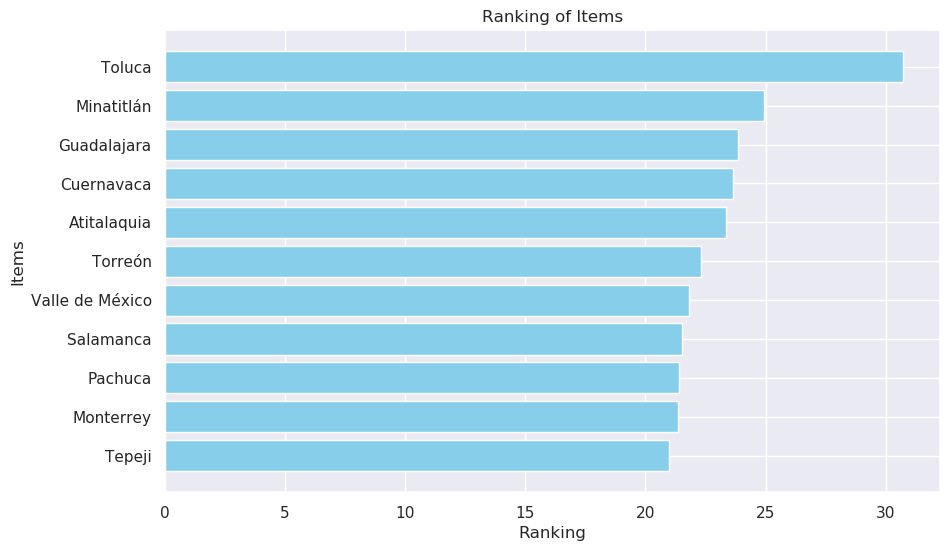

In [47]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

ranking = group_town["PM2.5"].mean().sort_values(ascending=False)[0:11]
ranking.index
# Plot the horizontal bar chart
plt.barh(ranking.index[::-1], ranking[::-1], color='skyblue')

# Customize labels and title
plt.xlabel('Ranking')
plt.ylabel('Items')
plt.title('Ranking of Items')

# # Display the chart
# plt.show()







# rank_graph = pd.DataFrame({"Average of PM2.5": group_town["PM2.5"].mean().nlargest(10)}).reset_index()
# rank_graph.plot("network_name", "Average of PM2.5", kind ='barh', color = '#4682B4', width = 0.5);
# plt.xlabel('PM2.5')
# plt.ylabel('city')
# plt.yticks(fontsize=8)
# plt.xticks(fontsize=8)
# plt.grid(False)
# plt.show()